<a href="https://colab.research.google.com/github/jpescobarn/AnaliticaDatos/blob/master/Ejercicio_1_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analítica de Datos 2020-2
### Ejercicio Final  
### Red Profunda 
#### Tomás Giraldo Agudelo - Juan Pablo Escobar Naranjo
--- 

## Objetivo

###Entrenar y evaluar un esquema de aprendizaje profundo mediante **CNNs**, Justificando la arquitectura empleada, tipo de capas, activaciones, inicializaciones, normalilzaciones, entre otros. Interpretar los resultados de la red y comparar los resultados obtenidos con clasificador logístico y una SVM lineal.





In [3]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#para acceder a archivos desde google drive en google colaboratory
#acceso a google drive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
#
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)
#
#file_id = '1TDxi5fWoS1zraYYsk0IfoVB0XQt--HJw' #copiar nombre nombre del link de compartir despues de ID
#downloaded = drive.CreateFile({'id': file_id})
#downloaded.GetContentFile('funciones_people.py') 
#from funciones_people import pre_exploratorio, save_fig, plot_confusion_matrix, roc_multiclass, roc_auc_mc

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
#base de datos
from sklearn.datasets import fetch_lfw_people
#https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

%matplotlib inline
#descargar base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

#ejemplo imagen en base de datos
#print('Dimensiones base de datos: \n',lfw_people.images.shape)
#plt.imshow(lfw_people.images[30,:,:],cmap='gray')

#print('Clases base de datos: \n',lfw_people['target_names'])
#print(lfw_people.images[30,:,:])

(1288,)
Hugo Chavez


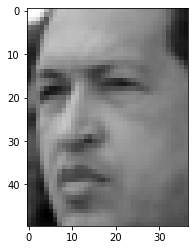

In [4]:
Xdata = lfw_people.images
y = lfw_people.target
plt.imshow(Xdata[0],cmap='gray')
print(y.shape)
print(lfw_people.target_names[y[0]])

## Preproceso

In [5]:
x_data= np.expand_dims(Xdata, axis=3)

x_train_full, x_test, y_train_full, y_test = train_test_split(x_data,y,test_size=0.2, random_state=42)

x_train, x_valid, y_train, y_valid = train_test_split(x_train_full,y_train_full,test_size=0.3)


In [6]:
print(x_train.shape)
print(lfw_people.data.shape)
y_train.shape

(721, 50, 37, 1)
(1288, 1850)


(721,)

##Se define el modelo a seguir

In [7]:
from functools import partial
import tensorflow as tf
from tensorflow import keras

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=3, input_shape=[lfw_people.images.shape[1], lfw_people.images.shape[2], 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    #DefaultConv2D(filters=256),
    #keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=500, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=100, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=7, activation='softmax'),
])

In [8]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Arquitectura seleccionada para la Red: Se establecen 4 capas convolucionales para extraer las características de las caras de los politicos, seguido de capas maxpooling para reducir los tamaños de la imagen, luego de las capas de características se agregan las capas de clasificación, capas densas una con 500 neuronas y otra con 100 neuronas, entre capas ponemos capas de dropout para evitar el sobre ajuste de la red.





In [12]:
#Construcción de los hiperparametros

# Se crea el modelo
# Parametros e hiperparametros
learning_rate=0.001
num_epoch = 100
batch     = 128

#optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)
#optimizer = tf.keras.optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999) 
#optimizer = tf.keras.optimizers.Adam(lr=learning_rate) 
optimizer = tf.keras.optimizers.SGD(lr=learning_rate, clipvalue=1.0)


model.summary()

# Se compila el modelo
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=num_epoch,
                      validation_data=(x_valid,y_valid))

score_test = model.evaluate(x_test, y_test, batch_size=batch)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 37, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 18, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 18, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 9, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 9, 128)        147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 4, 128)         1



### El número de épocas fue seleccionado como 100, teniendo en cuenta que según los resultados, la exactitud mantiene una relación directamente proporcional con las épocas, y que la función de error disminuye a medida que la exactitud aumenta. Se usa un optimizador no tan veloz, pero cuyo funcionamiento es eficiente para la tarea. 

### La tasa de aprendizaje, es la tasa con la que el optimizador aprende, este valor es el que mejor se acomoda. El lote o batch, define el número de ejemplos que se van a propagar en la red, obteniendo los mejores resultados con 128.

In [13]:
# ### Resumen de los parámetros, historial, y medidas de Loss y Accuracy

print('Resumen de la ejecución:\n')
print('Parámetros : ',history.params)
print('Claves que se calcularon : ',history.history.keys())

print('\nTest Loss:', score_test[0])
print('Test Accuracy: {:.2f}%'.format(100 * score_test[1]))

Resumen de la ejecución:

Parámetros :  {'verbose': 1, 'epochs': 100, 'steps': 23}
Claves que se calcularon :  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Test Loss: 0.28442102670669556
Test Accuracy: 91.86%


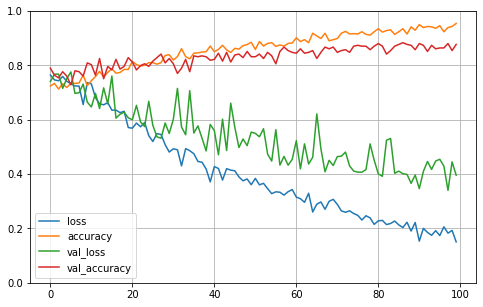

In [14]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig('grafica_train_validation_dropout.pdf', format='pdf', dpi=300)
#save_fig("keras_learning_curves_plot")
plt.show()


### La red neuronal establecida, con los parámetros mencionados anteriormente, arroja como resultado un acierto del 91.86% como máximo resultado obtenido después de varios ensayos. La función de pérdida fue seleccionada porque permite tener más de dos opciones en la última capa densa.

## Modelos por gridsearchCV utilizando pipeline

### Se seleccionan tres modelos a evaluar para el programa, **PCA_Logistic**, **PCA_SGD** y **SVCrbf**, cuyos parámetros fueron establecidos aleatoriamente en búsqueda de conveniencia y buenos resultados.

In [15]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

steps=[[('rep',  PCA()),
        ('cla', LogisticRegression())],
       [('rep',  PCA()),
        ('cla', SGDClassifier())],
        [('cla', SVC())]
      ]
parameters = [{
              'rep__n_components' : [0.8,0.9],              
              'cla__C': [0.5,1],
              },
              {
              'rep__n_components' : [0.8,0.9],              
              'cla__alpha': [0.0001,0.001],
              },
              {           
             'cla__C': [0.1,1,100,500,1e3],
             'cla__gamma': [0.01, 0.1, 1,10, 100,1e3]     
             }
             ]

label_models = ['PCA_Logistic','PCA_SGD', 'SVCrbf']

best_model = []
filename = ''#'resultados/people_comp'
for i in range(len(steps)):
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='balanced_accuracy',verbose=10)
    grid_search.fit(lfw_people.data, y)
    best_model += [grid_search.best_estimator_]
    joblib.dump(best_model,filename+".pkl")

print('Mejores modelos:\n')
best_model

modelo 1/3
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.1s finished


modelo 2/3
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.6s finished


modelo 3/3
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  7

Mejores modelos:



[Pipeline(memory=None,
          steps=[('rep',
                  PCA(copy=True, iterated_power='auto', n_components=0.9,
                      random_state=None, svd_solver='auto', tol=0.0,
                      whiten=False)),
                 ('cla',
                  LogisticRegression(C=0.5, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), Pipeline(memory=None,
          steps=[('rep',
                  PCA(copy=True, iterated_power='auto', n_components=0.9,
                      random_state=None, svd_solver='auto', tol=0.0,
                      whiten=False)),

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Después de realizar el proceso respectivo con cada modelo, obtenemos las matrices de confusión arrojadas por cada uno de ellos. 

Evaluando modelo 1/3


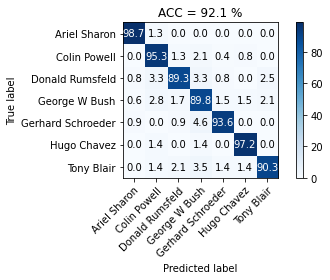

                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.99      0.96        77
     Colin Powell       0.91      0.95      0.93       236
  Donald Rumsfeld       0.87      0.89      0.88       121
    George W Bush       0.96      0.90      0.93       530
Gerhard Schroeder       0.89      0.94      0.91       109
      Hugo Chavez       0.85      0.97      0.91        71
       Tony Blair       0.90      0.90      0.90       144

         accuracy                           0.92      1288
        macro avg       0.90      0.93      0.92      1288
     weighted avg       0.92      0.92      0.92      1288

Evaluando modelo 2/3


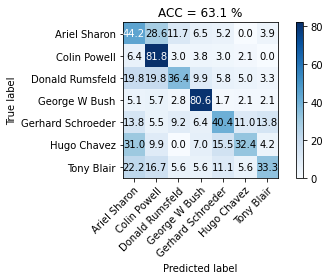

                   precision    recall  f1-score   support

     Ariel Sharon       0.20      0.44      0.28        77
     Colin Powell       0.63      0.82      0.71       236
  Donald Rumsfeld       0.47      0.36      0.41       121
    George W Bush       0.90      0.81      0.85       530
Gerhard Schroeder       0.45      0.40      0.43       109
      Hugo Chavez       0.35      0.32      0.34        71
       Tony Blair       0.57      0.33      0.42       144

         accuracy                           0.63      1288
        macro avg       0.51      0.50      0.49      1288
     weighted avg       0.66      0.63      0.64      1288

Evaluando modelo 3/3


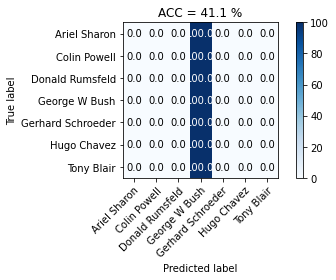

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        77
     Colin Powell       0.00      0.00      0.00       236
  Donald Rumsfeld       0.00      0.00      0.00       121
    George W Bush       0.41      1.00      0.58       530
Gerhard Schroeder       0.00      0.00      0.00       109
      Hugo Chavez       0.00      0.00      0.00        71
       Tony Blair       0.00      0.00      0.00       144

         accuracy                           0.41      1288
        macro avg       0.06      0.14      0.08      1288
     weighted avg       0.17      0.41      0.24      1288



In [17]:
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %d/%d' % (i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].predict(lfw_people.data)
    acc = accuracy_score(y,ytest_e)
     
    plot_confusion_matrix(
                          y, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()                    
    plt.show()
    
    cr = classification_report(
                               y, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    print(cr)


### El modelo que arrojó mejores resultados fue el modelo 1, PCA_Logistic, que obtuvo un 92.1% de acierto en la problemática del reconocimiento de los rostros de los políticos. La Red Neuronal creada, obtuvo un porcentaje también superior al 90% de acierto, lo que infiere que su desarrollo y aplicación fue exitoso.